In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
# Inicialización
import torch

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Definición de constantes 
import os

# esto es para que funcione matplotlib 
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

BATCH_SIZE = 32
EPOCHS = 30
IMAGE_SIZE = 28
DATASET_DIR = './data/'
MODELS_DIR = 'models/'

Using cpu device


In [5]:
from torchvision.io import read_image

sizes = []
for image in os.listdir('./data/images/colored_labels'):
    sizes.append(read_image("./data/images/colored_labels/" + image).shape)
print("Range for inputs with segmentation: ")
print(max(sizes))
print(min(sizes))

sizes = []
for image in os.listdir('./data/images/text_labels'):
    sizes.append(read_image("./data/images/text_labels/" + image).shape)
print("Range for inputs with txt: ")
print(max(sizes))
print(min(sizes))


Range for inputs with segmentation: 
torch.Size([3, 873, 550])
torch.Size([3, 801, 550])
Range for inputs with txt: 
torch.Size([3, 877, 550])
torch.Size([3, 786, 550])


No necesito que me prediga el color exacto de cada categoría, si sabe que es un vestido, luego busco en la tabla su color y listo:

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
classes = pd.read_csv(DATASET_DIR + "/class_dict.csv")

encoder = OneHotEncoder(sparse=False)

codes = encoder.fit_transform(classes[["r","g","b"]])
sum(codes)


array([3., 1., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 3., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1.,
       1., 1., 1., 2., 1., 2., 1., 2., 1., 3., 2., 6., 6.])

In [7]:
classes[["r","g","b"]]

,r,g,b
0,69,6,90
1,70,12,95
2,71,18,101
3,72,25,107
4,72,30,112
5,72,35,116
6,71,40,120
7,70,47,124
8,69,52,127
9,68,57,130


In [8]:

class CustomClothingDataset(Dataset):
    def __init__(self, root_dir, input_dir='images/colored_labels', 
                 labels_dir='labels/pixel_level_labels_colored',
                 transform=transforms.Compose([
                     transforms.Resize((560,560)), #size mayor de las imagenes, para todas iguales sin perder información
                     #transforms.Lambda(lambda x: x / 255), # reescalo de 0 a 1
                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# normalizo
                     #transforms.RandomHorizontalFlip() # data augmentation
        ])
                 ):
                        
        self.root_dir = root_dir
        self.input_dir = input_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = os.listdir(os.path.join(root_dir, self.input_dir))
        self.label_files = os.listdir(os.path.join(root_dir, self.labels_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.input_dir, self.image_files[idx])
        label_name = os.path.join(self.root_dir, self.labels_dir, self.label_files[idx])
        return ((self.transform(read_image(img_name).float())), 
                (self.transform(read_image(label_name).float())))

def get_class_weights(full_dataset, device):
    total_samples = len(full_dataset)

    class_counts = {}

    for _, label in full_dataset:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

    return torch.Tensor([total_samples / (3 * class_counts[i]) for i in range(3)]).to(device)


Cantidad de imágenes:  1004


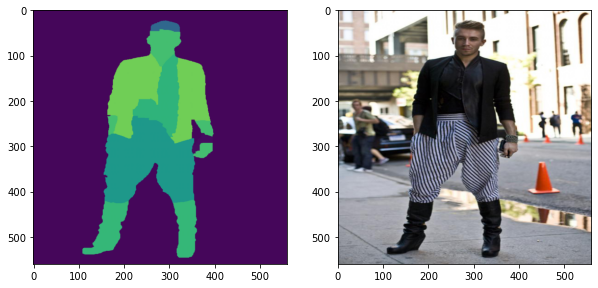

In [9]:
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

dataset = CustomClothingDataset(root_dir=DATASET_DIR)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
print("Cantidad de imágenes: ", len(data_loader.dataset))
for image, label in data_loader:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(label[0].int(), (1, 2, 0)))
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(image[0].int(), (1, 2, 0)))
    plt.show()
    break

## Implementación 1
### Modelo U-NET

Creación del modelo:

! Arreglar el problema de HorizontalFlip()

Hay que coger imagenes con el mismo grosor y altura para meterlos como input en la u-net, no vale `877x550` sino al mejor `560x560` para evitar coger el mayor porque puede generar ruido en la imagen, y tambien porque ese valor es divisible por 2 para pooling y unpooling, se prefiere compactarlo que generar ruido.

In [10]:
import torch
import torch.nn as nn

""" Convolutional block:
    It follows a two 3x3 convolutional layer, each followed by a batch normalization and a relu activation.
"""
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

""" Encoder block:
    It consists of an conv_block followed by a max pooling.
    Here the number of filters doubles and the height and width half after every block.
"""
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

""" Decoder block:
    The decoder block begins with a transpose convolution, followed by a concatenation with the skip
    connection from the encoder block. Next comes the conv_block.
    Here the number filters decreases by half and the height and width doubles.
"""
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x


class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 70)
        self.e2 = encoder_block(70, 140)
        self.e3 = encoder_block(140, 280)
        self.e4 = encoder_block(280, 560)

        """ Bottleneck """
        self.b = conv_block(560, 1120)

        """ Decoder """
        self.d1 = decoder_block(1120, 560)
        self.d2 = decoder_block(560, 280)
        self.d3 = decoder_block(280, 140)
        self.d4 = decoder_block(140, 70)

        """ Classifier """
        self.outputs = nn.Conv2d(70, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        """ Classifier """
        outputs = self.outputs(d4)

        return outputs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

inputs = torch.randn((2, 3, 560, 560)).to(device)
model = build_unet().to(device)
y = model(inputs)
print(y.shape)

torch.Size([2, 1, 560, 560])


In [11]:
BATCH_SIZE = 4 #32
EPOCHS = 1 #20
#IMAGE_SIZE = 560

In [12]:
dataset = CustomClothingDataset(root_dir=DATASET_DIR) # all images resized to 560x560
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True) # applying batches and random

In [13]:
all_images = []
all_segmentations = []

for images, segmentations in data_loader:
    all_images.append(images)
    all_segmentations.append(segmentations)
all_images = torch.cat(all_images, dim=0)
all_segmentations = torch.cat(all_segmentations, dim=0)

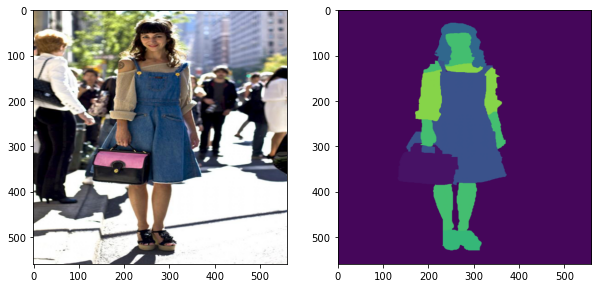

In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(all_images[50].int(), (1, 2, 0)))
plt.subplot(1, 2, 2)
plt.imshow(np.transpose(all_segmentations[50].int(), (1, 2, 0)))
plt.show()

In [15]:
print(len(all_images), len(all_segmentations))

1004 1004


In [16]:
all_images[0]

tensor([[[151.5643, 149.8507, 147.8929,  ..., 210.5214, 210.5214, 210.5214],
         [141.2571, 140.2839, 138.3464,  ..., 206.8464, 206.8464, 206.8464],
         [128.2321, 127.6586, 126.8752,  ..., 199.0179, 199.0231, 199.2143],
         ...,
         [197.5713, 188.2215, 191.2226,  ..., 136.5563, 150.1572, 129.2502],
         [199.1287, 195.5104, 205.5035,  ..., 152.6046, 156.1743, 131.9210],
         [204.2820, 199.8818, 204.6845,  ..., 122.3205, 131.2899, 141.8204]],

        [[140.8036, 139.8304, 138.3501,  ..., 201.7607, 201.7403, 201.0000],
         [132.6929, 131.7197, 131.6929,  ..., 198.8464, 198.8464, 198.8464],
         [122.6250, 122.4338, 123.1963,  ..., 194.4107, 194.4160, 194.6071],
         ...,
         [200.5713, 191.2215, 194.2226,  ..., 146.7527, 160.3536, 139.4467],
         [202.1287, 198.5104, 208.5035,  ..., 162.6046, 166.1743, 141.9210],
         [207.2820, 202.8818, 207.6845,  ..., 132.3205, 141.2899, 151.8204]],

        [[138.8036, 138.0632, 137.0875,  ...

In [17]:
total_samples = len(all_images)
train_samples = int(0.70 * total_samples)
val_samples = test_samples = int(0.15 * total_samples)

X_train = all_images[:train_samples]
Y_train = all_segmentations[:train_samples]

X_val = all_images[train_samples:train_samples + val_samples]
Y_val = all_segmentations[train_samples:train_samples + val_samples]

X_test = all_images[train_samples + val_samples:]
Y_test = all_segmentations[train_samples + val_samples:]

In [18]:
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))
print(len(X_test), len(Y_test))

702 702
150 150
152 152


In [19]:
train_dataset = TensorDataset(X_train, Y_train)
validation_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(),
                               lr=1e-3,
                               weight_decay=1e-5)


In [ ]:
# Training loop using train_loader with validation
for epoch in range(EPOCHS):
    # Training
    model.train()  # Set model to training mode
    for idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(val_loader):
            outputs = model(images.to(device))
            val_loss = criterion(outputs, labels.to(device))
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {loss.item():.4f}, Val Loss: {avg_val_loss:.4f}')


No puedo trabjar usando la CPU, aunque tenga 16GB de RAM, me da DefaultCPUAllocator: not enough memory: you tried to allocate 2809856000 bytes.

In [ ]:
# Testing 
model.eval()
total_test_loss = 0
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        outputs = model(images.to(device))
        test_loss = criterion(outputs, labels.to(device))
        total_test_loss += test_loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f'Average Test Loss: {avg_test_loss:.4f}')